<div class="jumbotron text-left"><b>

This Notebook provides an example of how to implement an Adaptive Design of Experiments (ADoE) algorithm to train a Multi-Fidelity Kriging (MFK) model, using only the SMT toolbox.

Example for 1D input and 2 levels of fidelity, using the Forrester function.

</b></div>

Maxime LALANDE, PhD Student ONERA/DMPE/HEAT - September 2025 - `version SMT 2.9.0 and above`






# Preliminary

### MFK

Please check doc https://smt.readthedocs.io/en/stable/_src_docs/applications/mfk.html

### ADOE

For further information about ADoE methods for MFK, please refer to Hugo Valayer's Master Internship Report: "*Multi-fidelity adaptive design of experiments and surrogate models for data fusion in aerodynamics*" - 2023.

### SMT
SMT is a joint library between NASA, UoM, ONERA and ISAE-SUPAERO. It offers many surrogate modeling tools with a focus on derivatives. Le Gratiet's formulation was implemented as part of SMT.

After dowmloading and installing SMT library from: https://github.com/SMTorg/smt

We import the needed packages

In [ ]:
!pip install smt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 963.3/963.3 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 kB 2.4 MB/s eta 0:00:00


# Personnal Motivation

This script was originally developed for my thesis work. It features some variations and additions to the algorithm described by H. Valayer in his report, needed for my use:

1.   Global point selection criterion $x_{n+1}$: implementation of MMSE, which is known to provide $x_{n+1}$ close to the boundaries of the design space. To prevent this, we can apply a weighting W to 'protect' the boundaries: W=0 'close to boundaries' and W=1 'inside' the design space. Tanh bridging function. Radius of influence of boundaries: parameter R_lim.

2.   Fidelity selection criteria: we consider 2 levels of fidelity, with cost $C_0$ for low-fidelity (LF) calculations and $C_1 > C_0$ for high-fidelity calculations. We use the criteria of Meliani et al. (AIAA, 2019): $\underset{l \in {0,1}}{\text{argmax}} \frac{\sigma_{cont}^2 (l, \textbf{x}^*) }{C_l^2}$, with $\sigma_{cont}^2 (l, \textbf{x}^*)$ the contribution of fidelity level $l$ to the surrogate model variance.

3.   Batch size $n_{b}$ possible. Instead of selecting only a single point $x_{n+1}$, we want $\{ x_{n+1}, ..., x_{n+n_b+1} \}$ points. A multistart search algorithm is used to find these points.

More info in my PhD Thesis (in french), Chapter 5 (should be Section 5.8, defense exptected in December 2025):

"Modélisation des phénomènes physiques fluide-structure associés à la dégradation thermochimique des matériaux en régime hypersonique continu lors de la rentrée atmosphérique des débris spatiaux"



In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl

from smt.utils.misc import compute_relative_error
from smt.applications.mfk import MFK, NestedLHS
from smt.sampling_methods import LHS
from smt.problems import LpNorm

from scipy.optimize import minimize

# General settings for the Forrester 1D2F Optimization

Parameters can be modify here for some tests

In [ ]:
path_py = os.getcwd() + "/"

# General settings
n_lvl = 2  # Number of fidelity levels
costs = [1, 10]  # Cost ratio [LF, HF]
d_min = 0.1  # Minimal distance (in [0;1]) between two new points. Default: d_min=0.15
# i.e.: let x1,x2 be 2 new possible points for curren iteration such as d(x1,x2) < d_min,
# then we only add the one with maximal RMSE.

rdm_state = 0  # For reproductibility of LHS
n_doe0_HF = 3  # Initial DOE size (high fidelity)
n_eval_pts = 201  # Number of points for rms evaluation
n_iter_max = 5  # Number max iterations for ADoE
tol_rmse = 1e-2  # RMSE tolerance for opti

# Training parameters (kernel, poly)
poly = "constant"
# poly = "linear"
# poly = "quadratic"
# corr = "matern32"
# corr = "matern52"
# corr = "pow_exp"
corr = "squar_exp"
xlimits = np.array([[0.0, 1.0]])  # Input bounds

# Enrichment criteria parameters
# Available: MMSE, MSEt
name_global_criteria = "MMSE"
y_t, eps_t_99 = 1, 1
var_t = (eps_t_99 / 3) ** 2
param_enrich = {
    "name_global_criteria": name_global_criteria,
    "y_t": y_t,
    "var_t": var_t,
}


# Setting n_multistart and batch_size for test
#    -- Test 1: n_multistart=1, batch_size=1 => Without multistart, global maximum is not found.
#    -- Test 2: n_multistart=100, batch_size=1 => With multistart, find global max. Fidelity selection criteria ok
#    -- Test 3: n_multistart=100, batch_size=3 => Validation of batching
#    -- Test 4: n_multistart=100, batch_size=3, R_lim = 0.25 => Validation of bounds weighting
n_test = 4
if n_test == 1:
    n_multistart = 1  # Number of multistart. At least n_multistart = batch_size, recommended 100*n_dim.
    batch_size = 1  # Number of new points to compute for each ADoE loop (batch)
    R_lim = 0
elif n_test == 2:
    n_multistart = 100  # Number of multistart. At least n_multistart = batch_size, recommended 100*n_dim.
    batch_size = 1  # Number of new points to compute for each ADoE loop (batch)
    R_lim = 0
elif n_test == 3:
    n_multistart = 100  # Number of multistart. At least n_multistart = batch_size, recommended 100*n_dim.
    batch_size = 3  # Number of new points to compute for each ADoE loop (batch)
    R_lim = 0
elif n_test == 4:
    n_multistart = 100  # Number of multistart. At least n_multistart = batch_size, recommended 100*n_dim.
    batch_size = 3  # Number of new points to compute for each ADoE loop (batch)
    R_lim = 0.05
else:  # defaut
    n_test = 0
    n_multistart = 10  # Number of multistart. At least n_multistart = batch_size, recommended 100*n_dim.
    batch_size = 2  # Number of new points to compute for each ADoE loop (batch)

dir_save = path_py + "fig_Forrester/test_{}/".format(n_test)
try:
    os.mkdir(dir_save)
except FileExistsError:
    pass

# LF and HF Functions

We define here the analytical low-fidelity and high-fidelity functions.

In [ ]:
def Forrester_HF(x):
    return ((6 * x - 2) ** 2) * np.sin(12 * x - 4)


def Forrester_LF(x):
    return 0.5 * ((6 * x - 2) ** 2) * np.sin(12 * x - 4) + 10 * (x - 0.5) - 5

# Enrichment criteria

#### Some utils functions



In [ ]:
def dist_norm(X1, X2, xlimits, order=2):
    r"""Normalized distance in [0;1] between X1 and X2
    X_i = (x_{i,j})_{j \in n_dim}   => x_{i,j} the n_dim components of X_i
    x_{i,j} \in [x_{j,min}, x_{j,max}] = [xlimits[j][0], xlimits[j][0]] => bounds of components j"""

    n_dim = xlimits.shape[0]

    # Lp norm
    Lp = LpNorm(ndim=n_dim, order=order)
    # Normalization in each dim
    norm = np.array([abs(x[1] - x[0]) for x in xlimits])
    X1_X2 = np.array([abs(X2[idim] - X1[idim]) / norm[idim] for idim in range(n_dim)])
    # Distance computation. Division by n_dim**(1/order) to ensure result in [0,1]
    return Lp(X1_X2.reshape((1, n_dim))) / (n_dim ** (1 / order))


def ME(
    lvl, sigma_delta, sigma_rho, theta_vol_lvl, costs, last_val=-np.inf, aversion=2.0
):
    """
    Model enhancement criterion - SEGO

    Parameters
    ----------
        lvl: integer
            index of level
        sigma_delta: array_like
            list of contributions (associated variance) for each level
        sigma_rho: array_like
            list of  scaling rho between each level (list of size number of levels - 1)
        theta_vol_lvl: array_like
            list with the associated volume of influence for each level
        costs: array_like
            list of associated costs for each fidelity level
        last_val: float
            associated value to the previous level in order to compute the threshold criterion
        aversion: float
            parameter to penalize the costs in the threshold criteria

    Returns
    -------
        bool, float if True
            = True if the new fildelity level k is prefered to previous level k-1
            = True if reduced sigma of level (k-1) < &e-16 (epsilon machine)
            = False if crit_k < crit_(k-1)
        mse: reduced sigma of level k

    Info: instead of comparing crit_k and crit_(k-1) where crit_k= mse_r(k)/(sum_k cost^ aversion)
    we compute here:
        log10 crit_k - log10 crit_(k-1)
        = log10 mse_r(k)-log10 mse_r(k-1) -aversion (log10 totalcost(k) - log10 totalcost(k-1))
        = log10 mse_r(k)-log10 (last val) -aversion log10(totalcost(k)/totalcost(k-1))
        = arg_1 - arg_2
    """
    mse_r = 0
    for i in range(lvl + 1):
        mse_r = mse_r + sigma_delta[i] * np.prod(sigma_rho[i:]) * theta_vol_lvl[i]

        if last_val < 1e-16:  # we are below the epsilon machine, crit is very low
            return True, mse_r

    arg_1 = np.log10(mse_r) - np.log10(last_val)
    arg_2 = aversion * np.log10((costs[lvl] + 0.0) / costs[lvl - 1])
    # if arg1 > arg2, it means crit_k > crit_(k-1) and level k is prefered
    return arg_1 > arg_2, mse_r


def var_red_2F(f, x, costs):
    """Return the reduced variance of LF and HF for a given x and model f"""
    nlvl = 2

    varAll, sigma_rho = f.predict_variances_all_levels(np.array([x]))

    sigma_delta = np.zeros((nlvl,))
    sigma_rho = np.array(sigma_rho)
    theta_vol_lvl = np.ones((nlvl,))
    flags = nlvl * [False]
    var_red = np.zeros((nlvl,))  # Variance reduction sigma_red

    sigma_delta[0] = varAll[0][0]
    sigma_delta[1] = varAll[0][1] - varAll[0][0] * sigma_rho[0][0]

    flags[0], var_red[0] = ME(0, sigma_delta, sigma_rho, theta_vol_lvl, costs)
    flags[1], var_red[1] = ME(
        1, sigma_delta, sigma_rho, theta_vol_lvl, costs, last_val=var_red[0]
    )

    return flags, var_red


def isInADOE(x, xlimits):
    # Verification  xlimits
    for i in range(len(xlimits)):
        if not xlimits[i][0] <= x[i] <= xlimits[i][1]:
            return False
    return True

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipython-input-2912954738.py:3: SyntaxWarning: invalid escape sequence '\i'
  X_i = (x_{i,j})_{j \in n_dim}   => x_{i,j} les n_dim composantes de X_i


#### Enrichment criteria

In [ ]:
# Global Criteria
def MMSE(f, x, sup_inp=None):
    """Maximum MSE => Minimum of -MSE"""
    return -f.predict_variances(x)[0, 0]


def MSEt(f, x, sup_inp):
    """Maximum Weighted MSE -> Gaussian weighting around a target value of the output y (H.Valayer)
    => Minimum of -MSEt"""
    y_t, var_t = sup_inp[0], sup_inp[1]

    def W_Heaviside(x, y_t):
        """Heaviside weighting - 0 if x < y_t, 1 else
        Just for testing, don't use, unconsistent, compare x (1D input) and y_t (scalar output)"""
        return np.heaviside(x - y_t, 0)

    def W_Gaussian(f, x, y_t, var_t):
        """Gaussian centered in y_t, with variance var_t"""
        A = (2 * np.pi * (var_t + f.predict_variances(x))) ** (-0.5)
        B = np.exp(
            -1
            / 2
            * ((f.predict_values(x) - y_t) ** 2)
            / (var_t + f.predict_variances(x))
        )
        return A * B

    # W = W_Heaviside(x, y_t)  # Testing
    W = W_Gaussian(f, x, y_t, var_t)
    return -f.predict_variances(x)[0, 0] * W[0, 0]


def glob_crit(name_global_criteria):
    if name_global_criteria == "MMSE":
        return MMSE
    if name_global_criteria == "MSEt":
        return MSEt


# Objetive function
def dist_boundary(x0, xlimits, R_lim, n_directions, tol=1e-3):
    """
    Approximation of L2 distance between point x0 and bounds of design space, defined by isInADOE function
    """

    x0 = np.array(x0, dtype=float)
    n_dim = xlimits.shape[0]
    min_dist = float("inf")

    for _ in range(n_directions):
        # Normalized random search direction
        u = np.random.normal(size=n_dim)
        u /= np.linalg.norm(u)

        # If for distance = R_lim we're still inside design space, direction ignored
        if isInADOE(x0 + R_lim * u, xlimits):
            continue

        # Dichotomy to approximate bounds distance
        t_low, t_high = 0.0, R_lim
        while t_high - t_low > tol:
            t_mid = 0.5 * (t_low + t_high)
            if isInADOE(x0 + t_mid * u, xlimits):
                t_low = t_mid
            else:
                t_high = t_mid

        min_dist = min(min_dist, t_low)

    return min_dist


def W_DOE_bounds(x0, xlimits, R_lim):
    """We look for the maximum radius R of the ball centered in x0, such as B(x0,R) is in DOE
    If: R > R_lim: weight = 1
    Else: weighting function in tanh. If R=0 => weight = 0
    """

    if R_lim <= 0:
        return 1
    else:
        R = dist_boundary(x0, xlimits, R_lim, n_directions=10)
        return (1 + np.tanh((R - R_lim / 1.5) / (R_lim / 5))) / 2


def obj_fun(f, x, xlimits, f_global_criteria, sup_inp, R_lim):
    """If R_lim > 0, weighting applied close to boundaries (caracteristic distance R_lim)
    with weight = 0 at bounds"""

    return f_global_criteria(f, np.array([x]), sup_inp) * W_DOE_bounds(
        x, xlimits, R_lim
    )


# Fidelity Criteria
def get_xnew_2F(f, x0, xlimits, costs, f_global_criteria, sup_inp, R_lim=0):
    def f0(x):
        # On transforme obj_fun(f, x, xlimits) en f0(x)
        return obj_fun(f, x, xlimits, f_global_criteria, sup_inp, R_lim)

    bounds = [(x[0], x[1]) for x in xlimits]

    res = minimize(f0, x0, method="TNC", bounds=bounds)
    x_new = res.x

    # Variance of lf and hf on x_new
    flags, var_red = var_red_2F(f, x_new, costs)

    # Value of the objectiv function at x_new
    crit_value = f0(x_new)

    if flags[1]:  # Add hf point
        return x_new, 1, var_red[1], crit_value
    else:  # Add lf point
        return x_new, 0, var_red[0], crit_value

# Plot Mean + Variance at each iteration

In [ ]:
fontsize = 15

params_plot_ref = {
    # 'legend.fontsize': fontsize,
    "figure.figsize": (7, 5),
    "axes.labelsize": fontsize,
    # 'axes.titlesize': 12,
    "xtick.labelsize": fontsize,
    "ytick.labelsize": fontsize,
    "lines.linewidth": 2.5,  # Default 1.5
    "lines.dotted_pattern": [1.0, 2.0],  # Default [1.0, 1.65]:
    "lines.markersize": 8.0,
}  # Default 6

pl.rcParams.update(pl.rcParamsDefault)
pl.rcParams.update(params_plot_ref)


def plot_TrueVsPredicted(sm, n_iter, xt_hf, yt_hf, x_rms, y_rms, dir_save=None):
    # Model prediction on HF training points
    y_eval = sm.predict_values(xt_hf)
    mse = sm.predict_variances(xt_hf)
    yerr = 3 * np.sqrt(mse)
    plt.figure(figsize=(7, 5))
    plt.plot(yt_hf, yt_hf, "-", label="$y_{true}$")
    plt.plot(yt_hf, y_eval, "r.", label=r"$\hat{y}$")
    plt.errorbar(
        np.squeeze(yt_hf),
        np.squeeze(y_eval),
        yerr=np.squeeze(yerr),
        fmt="none",
        capsize=5,
        ecolor="lightgray",
        elinewidth=1,
        capthick=0.5,
        label=r"$\pm 3\sigma$",
    )
    plt.xlabel("$y_{true}$")
    plt.ylabel(r"$\hat{y}$")
    plt.grid()
    plt.legend(loc="upper left", fontsize="large")
    x1, x2, y1, y2 = plt.axis()
    # plt.text((x2-x1)*0.3, 0.90*y2, "$||\sigma^2||_2 = {:.2e}$".format(np.linalg.norm(mse, ord=2)), fontsize = 'large')
    plt.title("MFK prediction on training HF data - Iteration = {}".format(n_iter))
    plt.tight_layout()
    if dir_save is not None:
        plt.savefig(dir_save + "ADoE_TrueVsPredicted_MFK_HF.pdf")
    plt.show()
    plt.close()

    # Model prediction on HF validation points
    y_eval = sm.predict_values(x_rms)
    mse = sm.predict_variances(x_rms)
    yerr = 3 * np.sqrt(mse)
    plt.figure(figsize=(7, 5))
    plt.plot(y_rms, y_rms, "-", label="$y_{true}$")
    plt.plot(y_rms, y_eval, "r.", label=r"$\hat{y}$")
    plt.errorbar(
        np.squeeze(y_rms),
        np.squeeze(y_eval),
        yerr=np.squeeze(yerr),
        fmt="none",
        capsize=5,
        ecolor="lightgray",
        elinewidth=1,
        capthick=0.5,
        label=r"$\pm 3\sigma$",
    )
    plt.xlabel("$y_{true}$")
    plt.ylabel(r"$\hat{y}$")
    plt.grid()
    plt.legend(loc="upper left", fontsize="large")
    x1, x2, y1, y2 = plt.axis()
    # plt.text((x2-x1)*0.3, 0.90*y2, "$||\sigma^2||_2 = {:.2e}$".format(np.linalg.norm(mse, ord=2)), fontsize = 'large')
    plt.title("MFK prediction on validation data - Iteration = {}".format(n_iter))
    plt.tight_layout()
    if dir_save is not None:
        plt.savefig(dir_save + "ADoE_TrueVsPredicted_MFK_ValidationDataset.pdf")
    plt.show()
    plt.close()


def plot_mean_var(
    n_iter,
    x0_LF,
    y0_LF,
    x0_HF,
    y0_HF,
    x_rms,
    costs,
    l_x_new,
    sm,
    fun_LF,
    fun_HF,
    xlimits,
    f_global_criteria,
    sup_inp,
    R_lim=0,
    dir_save=None,
):
    y_eval = sm.predict_values(x_rms)

    def f0(x):
        return obj_fun(sm, x, xlimits, f_global_criteria, sup_inp, R_lim)

    # MSE
    mse = sm.predict_variances(x_rms)

    # New point selection criteria
    crit = []
    for x in x_rms:
        crit.append(-f0(x))
    crit = np.array(crit)

    # New point fidelity level selection criteria
    var_red_LF, var_red_HF = [], []
    for x in x_rms:
        flags, var_red = var_red_2F(sm, x, costs)
        var_red_LF.append(var_red[0])
        var_red_HF.append(var_red[1])
    var_red_LF = np.array(var_red_LF)
    var_red_HF = np.array(var_red_HF)

    # Plot Variance
    plt.figure(figsize=(7, 5))
    plt.plot(x_rms, mse, "k--", label=r"MSE - $\sigma_y^2$")
    if R_lim > 0:
        plt.plot(x_rms, crit, "k-", label=r"MSEt - $W_{\mathcal{D}} \cdot \sigma_y^2$")
    if n_iter > 0:
        for ii in range(len(l_x_new)):
            plt.scatter(
                l_x_new[ii][0],
                -l_x_new[ii][3],
                color="magenta",
                marker="*",
                s=150,
                label="$x_{n+1}$" if ii == 0 else None,
                zorder=1000,
            )
    plt.plot(
        x_rms,
        var_red_HF / costs[1],
        "b:",
        label=r"$\sigma_{{red,HF}}^2 / {}^2$".format(costs[1]),
    )
    plt.plot(x_rms, var_red_LF, "r:", label=r"$\sigma_{red,LF}^2$")
    plt.xlabel("x")
    plt.ylabel("Variance")
    plt.xlim([-0.05, 1.05])
    if n_iter > 0:
        plt.title(
            "Iter = {} - RMSE = {:.3e}".format(
                n_iter, compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper center", borderaxespad=0.5, ncol=2, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == 0:
        plt.title(
            "Initialization - RMSE = {:.3e}".format(
                compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper center", borderaxespad=0.5, ncol=2, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == -1:
        plt.title(
            "Ens - RMSE = {:.3e}".format(
                compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper center", borderaxespad=0.5, ncol=2, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    plt.grid()
    plt.tight_layout()
    if n_iter > 0:
        if dir_save is not None:
            plt.savefig(dir_save + "Variance_Iter{}.pdf".format(n_iter))
    elif n_iter == 0:
        if dir_save is not None:
            plt.savefig(dir_save + "Variance_Iter_init.pdf")
    elif n_iter == -1:
        if dir_save is not None:
            plt.savefig(dir_save + "Variance_Iter_end.pdf")
    plt.show()
    plt.close()

    # Plot model and next point
    plt.figure(figsize=(7, 5))
    plt.plot(x_rms, fun_HF(x_rms), "--", label="HF Function")
    plt.plot(x_rms, fun_LF(x_rms), "--", label="LF Function")
    plt.scatter(x0_HF, y0_HF, marker="o", label="DoE HF", zorder=1000)
    plt.scatter(x0_LF, y0_LF, marker="o", label="DoE LF", zorder=1000)
    plt.plot(x_rms, y_eval, "g-", label="MFK model")
    plt.fill_between(
        np.ravel(x_rms),
        np.ravel(y_eval - 3 * np.sqrt(mse)),
        np.ravel(y_eval + 3 * np.sqrt(mse)),
        color="grey",
        alpha=0.4,
        label=r"$\pm 3 \sigma$",
    )
    if n_iter > 0:
        for ii in range(len(l_x_new)):
            if l_x_new[ii][1] == 0:
                plt.scatter(
                    l_x_new[ii][0],
                    fun_LF(l_x_new[ii][0]),
                    color="magenta",
                    marker="*",
                    s=150,
                    label="$x_{n+1}$" if ii == 0 else None,
                    zorder=1000,
                )
            else:
                plt.scatter(
                    l_x_new[ii][0],
                    fun_HF(l_x_new[ii][0]),
                    color="magenta",
                    marker="*",
                    s=150,
                    label="$x_{n+1}$" if ii == 0 else None,
                    zorder=1000,
                )
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim([-0.05, 1.05])
    plt.ylim([-12, 24])
    if n_iter > 0:
        plt.title(
            "Iter = {} - RMSE = {:.3e}".format(
                n_iter, compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper left", borderaxespad=0.5, ncol=4, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == 0:
        plt.title(
            "Initialization - RMSE = {:.3e}".format(
                compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper left", borderaxespad=0.5, ncol=3, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    elif n_iter == -1:
        plt.title(
            "End - RMSE = {:.3e}".format(
                compute_relative_error(sm, x_rms, fun_HF(x_rms))
            )
        )
        plt.legend(
            loc="upper left", borderaxespad=0.5, ncol=3, fontsize="medium"
        )  #  xx-small, x-small, small, medium, large, x-large, xx-large, larger
    plt.grid()
    plt.tight_layout()
    if n_iter > 0:
        if dir_save is not None:
            plt.savefig(dir_save + "Model_Iter{}.pdf".format(n_iter))
    elif n_iter == 0:
        if dir_save is not None:
            plt.savefig(dir_save + "Model_Iter_init.pdf")
    elif n_iter == -1:
        if dir_save is not None:
            plt.savefig(dir_save + "Model_Iter_end.pdf")
    plt.show()
    plt.close()

<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\h'
<>:47: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\h'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid escape sequence '\s'
<>:97: SyntaxWarning: invalid escape sequence '\s'
<>:129: SyntaxWarning: invalid escape sequence '\p'
<>:25: SyntaxWarning: invalid escape sequence '\h'
<>:28: SyntaxWarning: invalid escape sequence '\p'
<>:30: SyntaxWarning: invalid escape sequence '\h'
<>:47: SyntaxWarning: invalid escape sequence '\h'
<>:50: SyntaxWarning: invalid escape sequence '\p'
<>:52: SyntaxWarning: invalid escape sequence '\h'
<>:91: SyntaxWarning: invalid escape sequence '\s'
<>:92: SyntaxWarning: invalid escape sequence '\m'
<>:96: SyntaxWarning: invalid 

# Optimization algorithm

In [ ]:
def optim_1D_2F(
    xlimits,
    fun_LF,
    fun_HF,
    param_enrich,
    costs,
    n_lvl=2,
    n_doe0_HF=3,
    n_eval_pts=201,
    batch_size=1,
    n_multistart=1,
    rdm_state=0,
    n_iter_max=10,
    tol=1e-5,
    poly="constant",
    corr="squar_exp",
    d_min=0,
    R_lim=0,
    dir_save=None,
):
    n_dim = xlimits.shape[0]

    # Unpacking enrichment parameters
    f_global_criteria = glob_crit(param_enrich["name_global_criteria"])
    if param_enrich["name_global_criteria"] == "MSEt":
        sup_inp = [param_enrich["y_t"], param_enrich["var_t"]]
    else:
        sup_inp = None

    # Create initial DOE - Nested LHS method
    x0_lf, x0_hf = NestedLHS(nlevel=n_lvl, xlimits=xlimits, random_state=rdm_state)(
        n_doe0_HF
    )
    y0_lf, y0_hf = fun_LF(x0_lf), fun_HF(x0_hf)

    # Dataset for model evaluation of rmse
    x_rms = np.linspace(xlimits[:, 0], xlimits[:, 1], n_eval_pts)
    y_rms = fun_HF(x_rms)

    # Train initial model + Model evaluation: prediction and variance
    sm = MFK(theta0=[1.0] * n_dim, poly=poly, corr=corr, print_global=False)
    sm.set_training_values(x0_lf, y0_lf, name=0)
    sm.set_training_values(x0_hf, y0_hf)
    sm.train()

    print(
        "\nInitial MFK Model - LF/HF={}/{} - {}/{} - RMS Error: {:.3e}".format(
            x0_lf.shape[0],
            x0_hf.shape[0],
            poly,
            corr,
            compute_relative_error(sm, x_rms, y_rms),
        )
    )

    xt_lf, yt_lf = x0_lf, y0_lf
    xt_hf, yt_hf = x0_hf, y0_hf

    plot_TrueVsPredicted(sm, 0, xt_hf, yt_hf, x_rms, y_rms, dir_save=dir_save)
    plot_mean_var(
        0,
        x0_lf,
        y0_lf,
        x0_hf,
        y0_hf,
        x_rms,
        costs,
        None,
        sm,
        fun_LF,
        fun_HF,
        xlimits,
        f_global_criteria,
        sup_inp,
        R_lim=R_lim,
        dir_save=dir_save,
    )

    for n_iter in range(n_iter_max):
        l_x_new = []

        # LHS with points used as initial guess for multistary method
        if n_multistart >= batch_size:
            LHS_multistart = LHS(xlimits=xlimits, random_state=n_iter)(n_multistart)
        else:
            print("Error: increase n_multistart")

        for idx, x0 in enumerate(LHS_multistart):
            # New point selection
            x_new, fid_new, var_red, crit_value = get_xnew_2F(
                sm, x0, xlimits, costs, f_global_criteria, sup_inp, R_lim
            )

            # Add point to list of new points, only if in DOE
            # NB: TNC minimization method used, no-constraints and no-bounds method, so new points could be outside DOE
            if isInADOE(x_new, xlimits):
                l_x_new.append([x_new, fid_new, var_red, crit_value])

        # Sorting by increasing crit_value  (crit_value < 0, we prioritise the largest local minima)
        l_x_new = sorted(l_x_new, key=lambda x: x[3])

        # Points that are too close together are removed.
        l_x_reduced = [
            l_x_new[0]
        ]  # List of points to keep. The worst point is inevitably kept.
        for id_x in range(1, len(l_x_new)):
            # For point id_x, we compare its distance with the points already stored.
            # point removed if there i in [0, id_x-1] such that d(x_i,x_idx) < d_min
            to_keep = True
            for xi in l_x_reduced:
                if dist_norm(l_x_new[id_x][0], xi[0], xlimits, order=2) < d_min:
                    to_keep = False
            if to_keep:
                l_x_reduced.append(l_x_new[id_x])

        # list truncated to take only the first batch_size items.
        l_x_trunc = l_x_reduced[:batch_size]

        plot_mean_var(
            n_iter + 1,
            xt_lf,
            yt_lf,
            xt_hf,
            yt_hf,
            x_rms,
            costs,
            l_x_trunc,
            sm,
            fun_LF,
            fun_HF,
            xlimits,
            f_global_criteria,
            sup_inp,
            R_lim=R_lim,
            dir_save=dir_save,
        )

        # Adding x_new to xt_lf / xt_hf
        for ii in range(len(l_x_trunc)):
            x_new = l_x_trunc[ii][0]
            fid_new = l_x_trunc[ii][1]
            xt_lf = np.concatenate((xt_lf, np.array([x_new])))
            yt_lf = np.concatenate((yt_lf, np.array([fun_LF(x_new)])))
            if fid_new == 1:
                xt_hf = np.concatenate((xt_hf, np.array([x_new])))
                yt_hf = np.concatenate((yt_hf, np.array([fun_HF(x_new)])))

        # Train new model
        sm = MFK(theta0=[1.0] * n_dim, poly=poly, corr=corr, print_global=False)
        sm.set_training_values(xt_lf, yt_lf, name=0)
        sm.set_training_values(xt_hf, yt_hf)
        sm.train()

        print(
            "\nIter = {} - LF/HF={}/{} - {}/{} - RMS Error: {:.3e}".format(
                n_iter,
                xt_lf.shape[0],
                xt_hf.shape[0],
                poly,
                corr,
                compute_relative_error(sm, x_rms, y_rms),
            )
        )

        if compute_relative_error(sm, x_rms, fun_HF(x_rms)) < tol:
            break

    # Final Model
    plot_mean_var(
        -1,
        xt_lf,
        yt_lf,
        xt_hf,
        yt_hf,
        x_rms,
        costs,
        l_x_trunc,
        sm,
        fun_LF,
        fun_HF,
        xlimits,
        f_global_criteria,
        sup_inp,
        R_lim=R_lim,
        dir_save=dir_save,
    )
    plot_TrueVsPredicted(sm, n_iter, xt_hf, yt_hf, x_rms, y_rms, dir_save=dir_save)

# Run test


Initial MFK Model - LF/HF=6/3 - constant/squar_exp - RMS Error: 1.249e+00


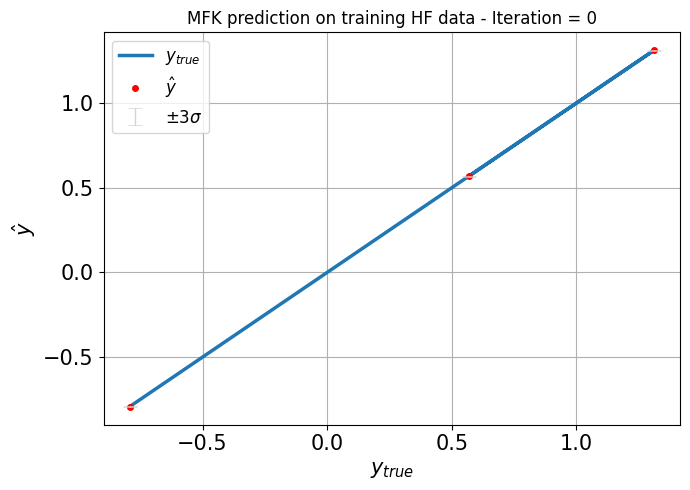

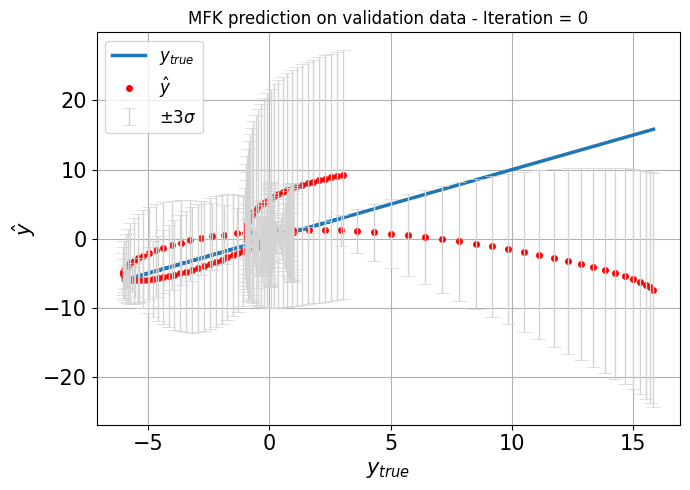

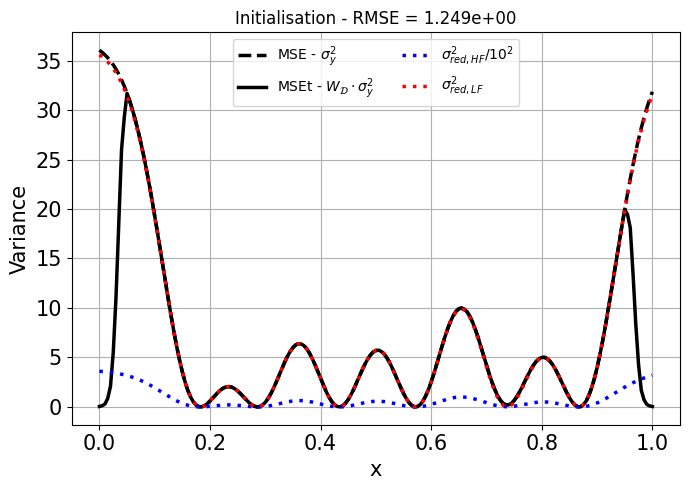

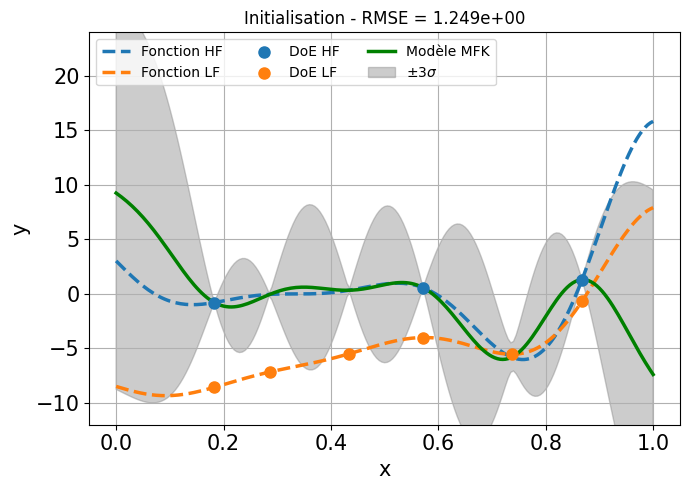

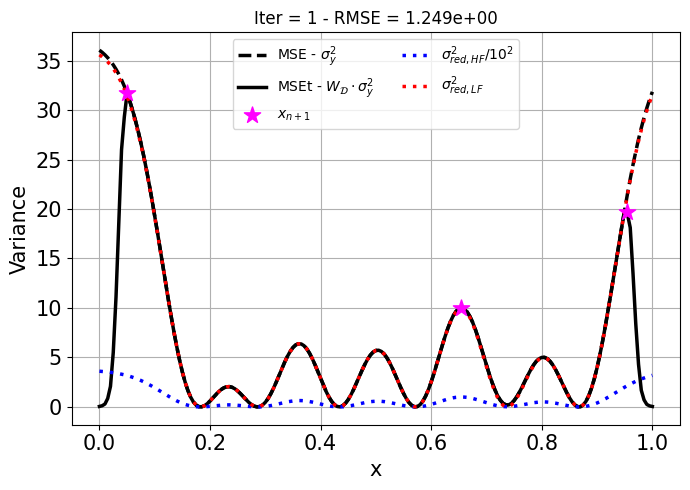

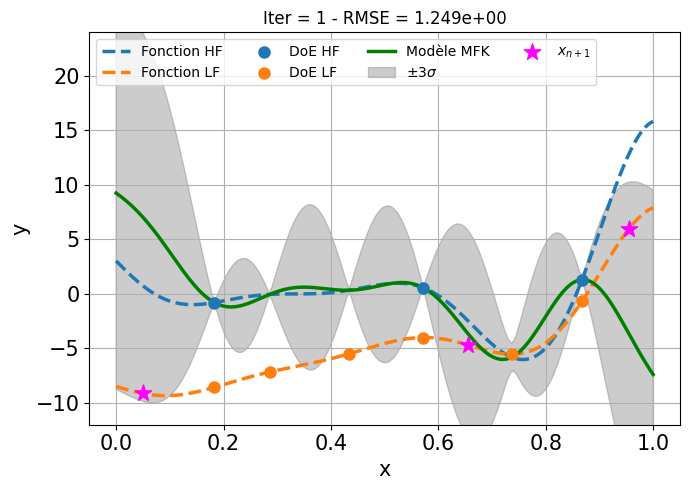


Iter = 0 - LF/HF=9/3 - constant/squar_exp - RMS Error: 3.747e-02


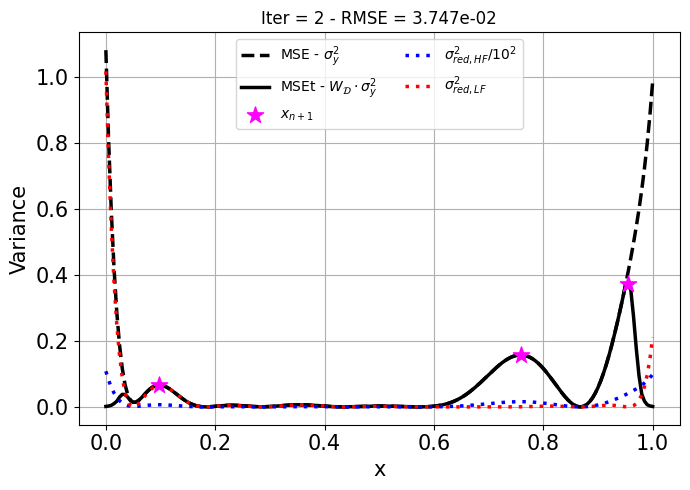

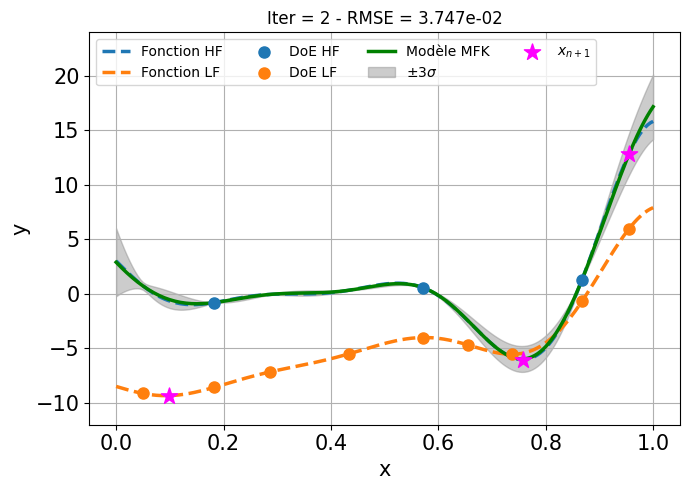


Iter = 1 - LF/HF=12/5 - constant/squar_exp - RMS Error: 4.400e-03


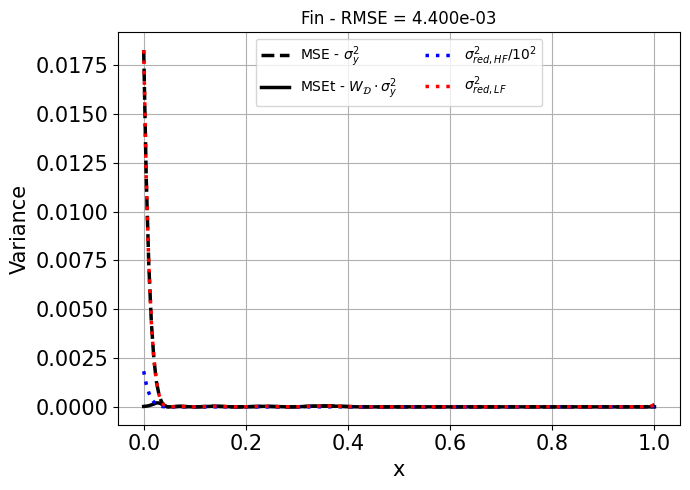

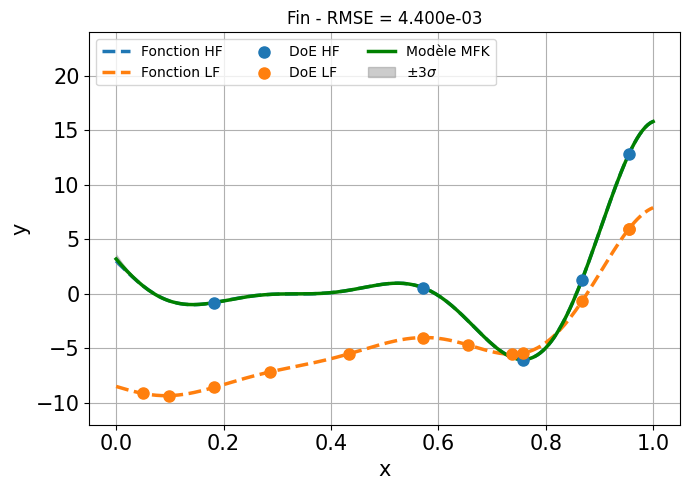

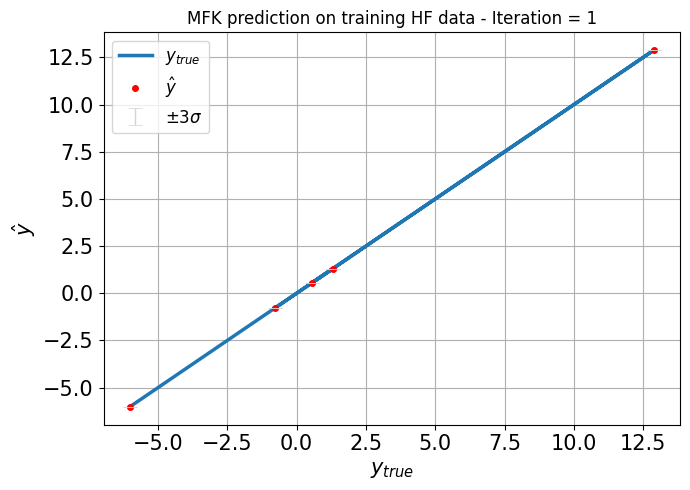

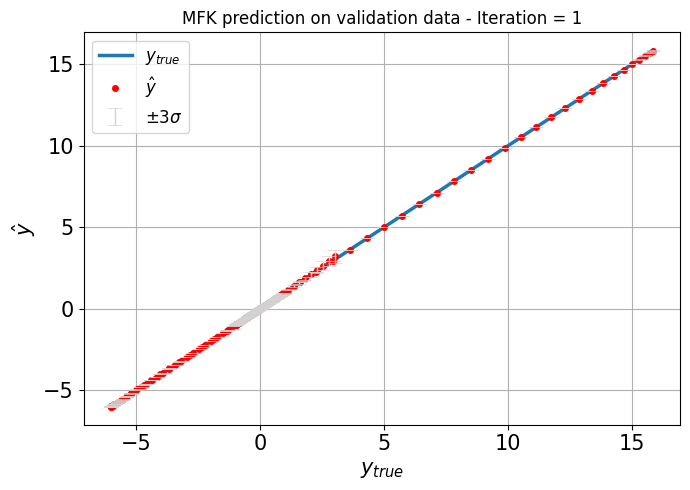

In [22]:
optim_1D_2F(
    xlimits,
    Forrester_LF,
    Forrester_HF,
    param_enrich,
    costs,
    n_lvl=n_lvl,
    n_doe0_HF=n_doe0_HF,
    n_eval_pts=n_eval_pts,
    batch_size=batch_size,
    n_multistart=n_multistart,
    rdm_state=rdm_state,
    n_iter_max=n_iter_max,
    tol=tol_rmse,
    poly=poly,
    corr=corr,
    d_min=d_min,
    R_lim=R_lim,
    dir_save=dir_save,
)